# Resting EEG Data

This notebook analyzes a dataset of EEG data collected from healthy young adults.

## Dataset Details

This dataset is a dataset of extra-cranial EEG data recorded in the Voytek Lab. 

Analyzed data is taken from eyes-closed resting state data collected prior to a visual-detection psychophysics task.

In [1]:
import os
from pathlib import Path

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

from antropy import app_entropy

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

from bootstrap import bootstrap_corr

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_68674/4025414407.py:10: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.core.db import APMDB
from apm.core.io import get_files
from apm.run import run_measures
from apm.plts import plot_dots
from apm.utils import format_corr
from apm.methods import specparam, lempelziv, hjorth_complexity, dfa, hurst, irasa

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Define the data folder
folder = Path('/Users/tom/Data/VoytekLab/ExtractedSubsets/eeg_data')

In [5]:
# Define data field to extract from files
data_field = 'oz_rest_data'

In [6]:
# Define data information
fs = 500
n_seconds = 120

In [7]:
# Define times vector for data
times = create_times(n_seconds, fs)

In [8]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '31_eeg_data'

## Load Data


In [9]:
# Get the list of available files
files = get_files(folder, select='.mat')

In [10]:
# FIX: temporarily drop subject which has a data quirk (wrong size array)
files.remove('1009.mat')

In [11]:
# Check the number of subjects
n_subjs = len(files)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 28


In [12]:
# Collect and load all data segments
data = []
for file in files:
    loaded = loadmat(folder / file, squeeze_me=True)
    data.append(loaded[data_field])
data = np.array(data)

## Data Checks

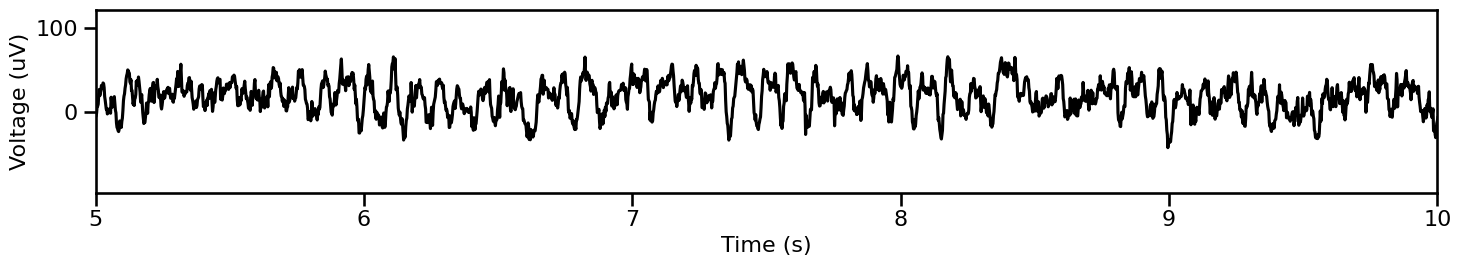

In [13]:
# Plot a segment of time series data
plot_time_series(times, data[0, :], xlim=[5, 10])

In [14]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[0, :], fs, nperseg=2*fs, noverlap=fs)

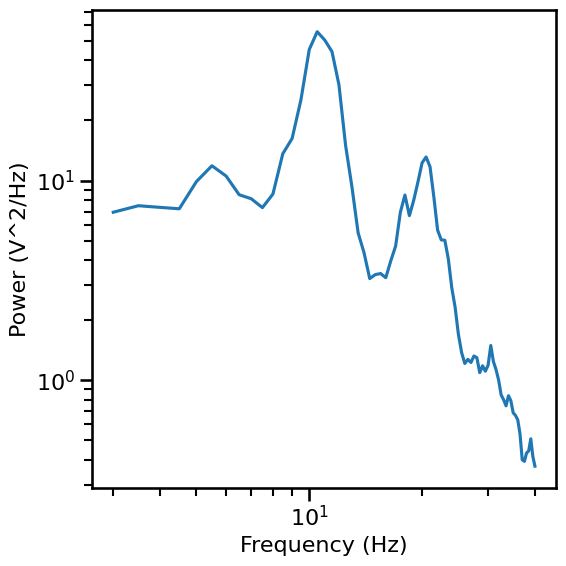

In [15]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]))

## Compare Methods

In [16]:
# General method settings
f_range = [3, 40]

In [17]:
# Initialize specparam model
fm = FOOOF(verbose=False)

In [18]:
# Define measures to apply
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    hurst : {'fs' : fs},
    dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [19]:
# Compute measures of interest on the data
outputs = run_measures(data, measures)

#### Compare Exponent Measures

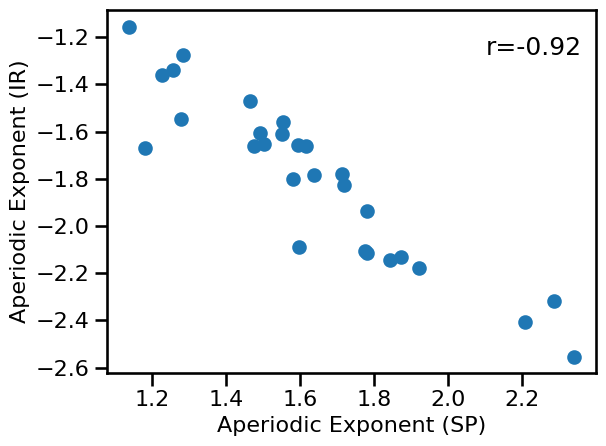

In [20]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(outputs['specparam'], outputs['irasa'],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='eeg_exp_exp_comp' + EXT, file_path=FIGPATH)

In [21]:
# Check the correlation
sp_ir_corrs = bootstrap_corr(outputs['specparam'], outputs['irasa'])
print('  SP-EXP & IR-EXP:  ', format_corr(*sp_ir_corrs))

  SP-EXP & IR-EXP:   r=-0.920  CI[-0.980, -0.762],  p=0.000


#### Compare exponent to LZ Complexity

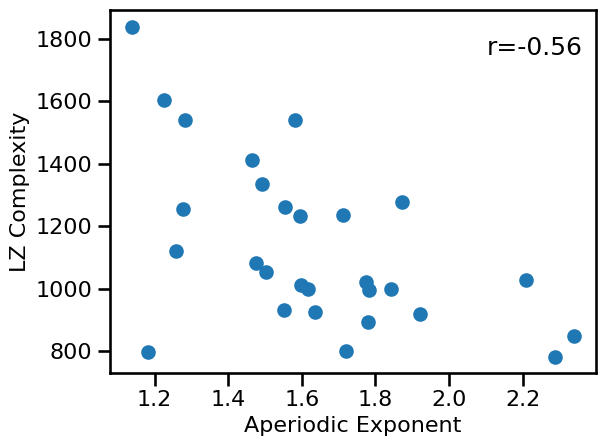

In [22]:
# Plot the comparison of specparam and lempel-ziv complexity
plot_dots(outputs['specparam'], outputs['lempelziv'],
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity',
          save_fig=SAVE_FIG, file_name='eeg_exp_lz_comp' + EXT, file_path=FIGPATH)

In [23]:
# Check the correlation
spexp_lzc_corrs = bootstrap_corr(outputs['specparam'], outputs['lempelziv'])
irexp_lzc_corrs = bootstrap_corr(outputs['irasa'], outputs['lempelziv'])
print('  SP-EXP & LZC:  ', format_corr(*spexp_lzc_corrs))
print('  IR-EXP & LZC:  ', format_corr(*irexp_lzc_corrs))

  SP-EXP & LZC:   r=-0.561  CI[-0.840, -0.152],  p=0.002
  IR-EXP & LZC:   r=+0.649  CI[+0.358, +0.842],  p=0.000


#### Compare exponent to entropy

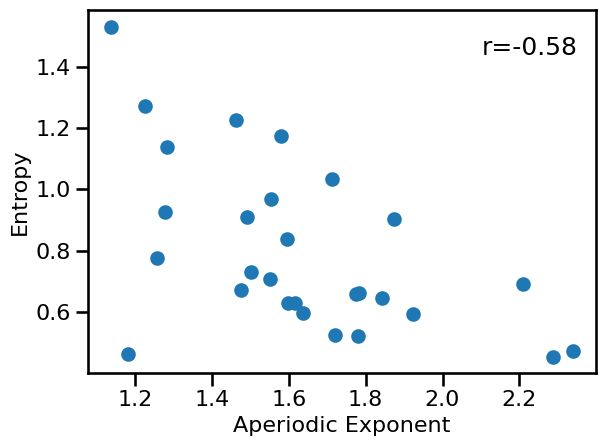

In [24]:
# Plot the comparison of specparam and approximate entropy
plot_dots(outputs['specparam'], outputs['app_entropy'],
          xlabel='Aperiodic Exponent', ylabel='Entropy',
          save_fig=SAVE_FIG, file_name='eeg_exp_ent_comp' + EXT, file_path=FIGPATH)

In [25]:
# Check the correlation
spexp_ent_corrs = bootstrap_corr(outputs['specparam'], outputs['app_entropy'])
irexp_ent_corrs = bootstrap_corr(outputs['irasa'], outputs['app_entropy'])
print('  SPEXP & ENT:  ', format_corr(*spexp_ent_corrs))
print('  IREXP & ENT:  ', format_corr(*irexp_ent_corrs))

  SPEXP & ENT:   r=-0.577  CI[-0.844, -0.196],  p=0.001
  IREXP & ENT:   r=+0.691  CI[+0.418, +0.864],  p=0.000


## Conclusions

Conclusions of this empirical data analysis thus far:
- in this EEG data, the specparam & IRASA exponent estimates are highly comparable
- in this empirical data, aperiodic exponent is moderately correlated with the time domain methods

Note that this dataset is analyzed as a small / pilot, such that these interim conclusions are not considered decisive, and are best considered as initial results to be further explored and replicated in subsequent larger datasets.